# SWaT Anomaly Detection with USAD

by dongmin kim (tommy.dm.kim@gmail.com)

In [1]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import easydict

# Load data

In [2]:
from data.load_data import load_data

SWAT_TRAIN_PATH = './data/SWaT/SWaT_Dataset_Normal_v0.csv'
SWAT_TEST_PATH = './data/SWaT/SWaT_Dataset_Attack_v0.csv'
train_x, train_y = load_data(SWAT_TRAIN_PATH)
test_x, test_y = load_data(SWAT_TEST_PATH)

In [5]:
args = easydict.EasyDict({
    "batch_size": 128,
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
    "input_size": train_x.shape[1],
    "latent_size": 10,
    "output_size": train_x.shape[1],
    "window_size" : 100,
    "num_layers": 2,
    "learning_rate" : 0.001,
    "max_iter" : 100000,
    'early_stop' : True,
})

In [6]:
from data.dataset import SWaTDataset

train_dataset = SWaTDataset(train_x, train_y, window_size=args.window_size)
test_dataset = SWaTDataset(test_x, test_y, window_size=args.window_size)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=args.batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=args.batch_size,
                shuffle=False)

# Model

In [8]:
from USAD.model import USAD

model = USAD(
    input_size= args.input_size,
    latent_space_size= args.latent_size
)
model.to(args.device)

USAD(
  (encoder): Encoder(
    (linear1): Linear(in_features=51, out_features=25, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=25, out_features=12, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=12, out_features=10, bias=True)
    (relu3): ReLU()
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=10, out_features=12, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=12, out_features=25, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=25, out_features=51, bias=True)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (linear1): Linear(in_features=10, out_features=12, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=12, out_features=25, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=25, out_features=51, bias=True)
    (sigmoid): Sigmoid()
  )
)

# Loss Function

In [26]:
MSE = nn.MSELoss()
def loss_function(Wt, Wt1p, Wt2p, Wt2dp, n):
    """
        :param Wt: ground truth sequence
        :param Wt1p: AE1 decoder output
        :param Wt2p: AE2 decoder output
        :param Wt2dp: AE1 encoder output => AE2 decoder
        :param n: Training epochs
    """
    loss_AE1 = (1/n) * MSE(Wt, Wt1p) + (1-(1/n)) * MSE(Wt, Wt2dp)
    loss_AE2 = (1/n) * MSE(Wt, Wt2p) - (1-(1/n)) * MSE(Wt, Wt2dp)
    return loss_AE1 + loss_AE2

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

In [28]:
## Training
best_loss = None
epochs = tqdm(range(args.max_iter//len(train_loader)+1), leave=True)
for epoch in epochs:
    model.train()
    optimizer.zero_grad()
    train_iterator = tqdm(enumerate(train_loader), total=len(train_loader), desc="training", leave=True)

    train_loss = 0.0
    for i, batch_data in train_iterator:
        batch_data = batch_data[0].to(args.device)

        z = model.encoder(batch_data)
        Wt1p = model.decoder1(z)
        Wt2p = model.decoder2(z)
        Wt2dp = model.decoder2(model.encoder(Wt1p))

        optimizer.zero_grad()
        loss = loss_function(batch_data, Wt1p, Wt2p, Wt2dp, epoch+1)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iterator.set_postfix({
            "train_loss": float(loss),
        })

    train_loss = train_loss / len(train_loader)
    epochs.set_postfix({
         "Train Loss": train_loss,
    })

    model.eval()
    eval_loss = 0
    test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing", leave=True)
    with torch.no_grad():
        for i, batch_data in test_iterator:

            batch_data = batch_data[0].to(args.device)

            z = model.encoder(batch_data)
            Wt1p = model.decoder1(z)
            Wt2p = model.decoder2(z)
            Wt2dp = model.decoder2(model.encoder(Wt1p))

            loss = loss_function(batch_data, Wt1p, Wt2p, Wt2dp, epoch+1)
            eval_loss += loss.mean().item()

            test_iterator.set_postfix({
                "eval_loss": float(loss),
            })

    eval_loss = eval_loss / len(test_loader)
    epochs.set_postfix({
         "Evaluation Score": float(eval_loss),
    })
    if best_loss is None or eval_loss < best_loss:
        best_loss = eval_loss
    else:
        if args.early_stop:
            print('early stop condition   best_loss[{}]  eval_loss[{}]'.format(best_loss, eval_loss))
            break


  0%|          | 0/26 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

training:   0%|          | 0/3881 [00:00<?, ?it/s]

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

In [50]:
MSE = torch.nn.MSELoss(reduce=False)

def get_anomaly_score(Wt, model, alpha = 0.5, beta = 0.5):
    z = model.encoder(Wt)
    Wt1p = model.decoder1(z)
    Wt2dp = model.decoder2(model.encoder(Wt1p))
    return alpha * MSE(Wt, Wt1p) + beta * MSE(Wt, Wt2dp)

test_iterator = tqdm(enumerate(test_loader), total=len(test_loader), desc="testing")
anomaly_score_list = []
with torch.no_grad():
    for i, batch_data in test_iterator:
        batch_data = batch_data[0].to(args.device)
        anomaly_score = get_anomaly_score(batch_data, model).mean(axis=(1, 2)).to("cpu")
        anomaly_score_list.append(anomaly_score)

anomaly_scores = np.concatenate(anomaly_score_list, axis=0)

testing:   0%|          | 0/3515 [00:00<?, ?it/s]

In [51]:
anomaly_scores.shape

(449820,)

In [52]:
x = list(range(len(anomaly_scores)))
y = anomaly_scores

window_y = []
for i in x:
    window_y.append(min(test_y[i:i+args.window_size])==1)

intervals = []
start = None
for i, label in enumerate(window_y):
    if label:
        if start is None:
            start = i
    else:
        if start is not None:
            intervals.append((start, i-1))
        start = None
if start is not None:
    intervals.append((start, len(window_y)-1))

In [53]:
print(intervals)

[(1754, 2594), (3068, 3411), (4920, 5203), (6459, 6749), (7255, 7351), (7705, 8034), (11410, 12274), (15380, 16001), (73800, 74421), (90685, 90818), (92140, 92471), (93445, 93621), (103092, 103709), (115843, 116002), (116143, 116438), (117000, 117621), (132918, 133281), (142954, 143551), (172305, 172489), (172910, 173422), (198296, 199641), (227828, 263628), (279120, 279141), (280060, 281131), (302653, 302920), (347679, 348180), (361191, 361535), (371479, 371480), (371855, 372236), (389680, 390120), (436541, 436910), (437417, 437598), (438147, 438448), (438621, 438818), (443501, 445091)]


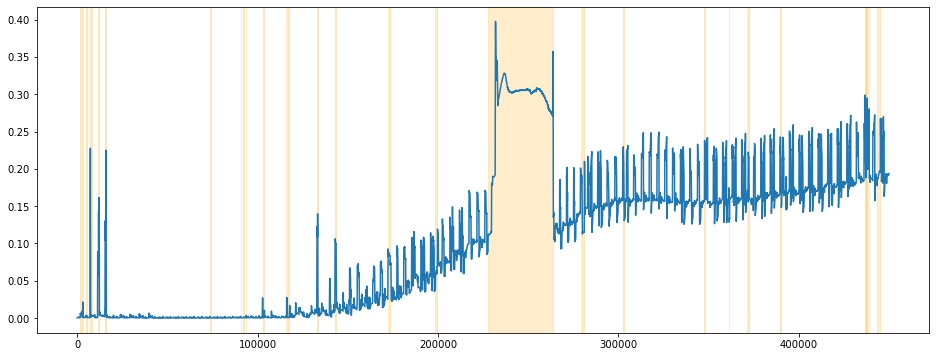

In [54]:
## 시각화 하기
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot()

ax.plot(x, y)
plt.rcParams['axes.facecolor']='white'
for s, e in intervals:
    ax.axvspan(s, e, alpha=0.2, color='orange')

### Finding Threshold

In [55]:
len(anomaly_scores), anomaly_scores[0]

(449820, 0.000492936)

In [56]:
anomaly_min, anomaly_max = np.min(anomaly_scores), np.max(anomaly_scores)
anomaly_min, anomaly_max

(0.0001858621, 0.39747947)

In [57]:
test_y.shape

(449919,)

In [58]:
thresholds = np.linspace(anomaly_min, anomaly_max, 100)

In [59]:
print(thresholds)

[1.85862096e-04 4.19892889e-03 8.21199568e-03 1.22250625e-02
 1.62381293e-02 2.02511961e-02 2.42642629e-02 2.82773296e-02
 3.22903964e-02 3.63034632e-02 4.03165300e-02 4.43295968e-02
 4.83426636e-02 5.23557304e-02 5.63687972e-02 6.03818640e-02
 6.43949308e-02 6.84079976e-02 7.24210644e-02 7.64341312e-02
 8.04471979e-02 8.44602647e-02 8.84733315e-02 9.24863983e-02
 9.64994651e-02 1.00512532e-01 1.04525599e-01 1.08538665e-01
 1.12551732e-01 1.16564799e-01 1.20577866e-01 1.24590933e-01
 1.28603999e-01 1.32617066e-01 1.36630133e-01 1.40643200e-01
 1.44656267e-01 1.48669333e-01 1.52682400e-01 1.56695467e-01
 1.60708534e-01 1.64721601e-01 1.68734667e-01 1.72747734e-01
 1.76760801e-01 1.80773868e-01 1.84786935e-01 1.88800001e-01
 1.92813068e-01 1.96826135e-01 2.00839202e-01 2.04852269e-01
 2.08865335e-01 2.12878402e-01 2.16891469e-01 2.20904536e-01
 2.24917602e-01 2.28930669e-01 2.32943736e-01 2.36956803e-01
 2.40969870e-01 2.44982936e-01 2.48996003e-01 2.53009070e-01
 2.57022137e-01 2.610352

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [61]:
import seaborn as sns

In [62]:
len(anomaly_scores), len(test_y)

(449820, 449919)

In [63]:
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    anomaly_prediction = (anomaly_scores > threshold).astype(int)
    target_y = test_y[args.window_size-1:]


    tn, fp, fn, tp = confusion_matrix(target_y, anomaly_prediction).ravel()

    p, r, f = precision_score(target_y, anomaly_prediction, zero_division = 1), recall_score(target_y, anomaly_prediction, zero_division = 1), f1_score(target_y, anomaly_prediction, zero_division = 1)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)

    print(f"threshold {threshold} | tn {tn} fp {fp} fn {fn} tp {tp} p {p} r {r} f {f}")
    print(p, r, f)


threshold 0.00018586209625937045 | tn 1 fp 395235 fn 0 tp 54584 p 0.12134658607128646 r 1.0 f 0.21643011639502538
0.12134658607128646 1.0 0.21643011639502538
threshold 0.004198928888666096 | tn 115910 fp 279326 fn 4468 tp 50116 p 0.152123894342555 r 0.9181445112120769 f 0.26100316124429074
0.152123894342555 0.9181445112120769 0.26100316124429074
threshold 0.008211995681072821 | tn 128980 fp 266256 fn 5564 tp 49020 p 0.15548281505728315 r 0.898065367140554 f 0.2650732709673931
0.15548281505728315 0.898065367140554 0.2650732709673931
threshold 0.012225062473479546 | tn 137633 fp 257603 fn 5962 tp 48622 p 0.15877867581027022 r 0.8907738531437784 f 0.269516558622429
0.15877867581027022 0.8907738531437784 0.269516558622429
threshold 0.016238129265886272 | tn 144401 fp 250835 fn 6042 tp 48542 p 0.16214338442832948 r 0.8893082221896527 f 0.27427880472707444
0.16214338442832948 0.8893082221896527 0.27427880472707444
threshold 0.020251196058292998 | tn 150225 fp 245011 fn 6116 tp 48468 p 0.1651

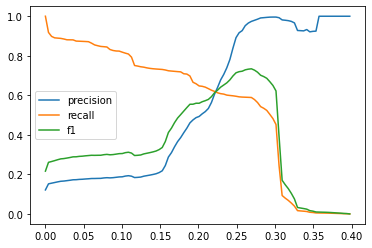

In [64]:
plt.plot(thresholds, precisions, label = "precision")
plt.plot(thresholds, recalls, label = "recall")
plt.plot(thresholds, f1s, label = "f1")
plt.legend()
plt.show()

In [65]:
threshold_idx = np.argmax(f1s)

In [66]:
best_threshold = thresholds[threshold_idx]

In [67]:
best_threshold

0.26906133718750996

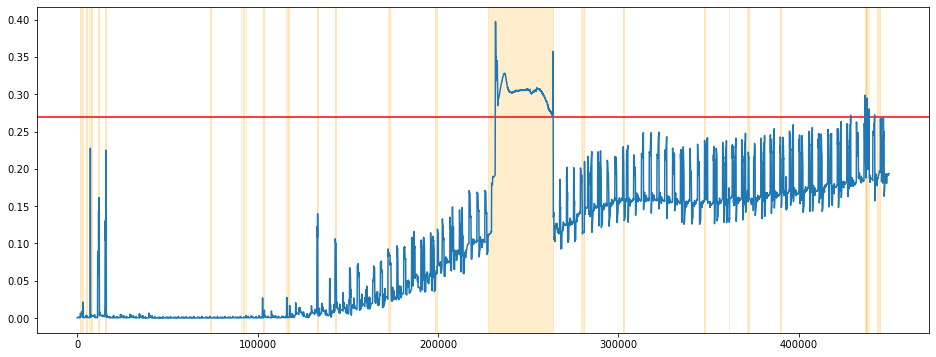

In [68]:
fig = plt.figure(figsize=(16, 6))
ax=fig.add_subplot()
ax.axhline(y = best_threshold, color = "r")
ax.plot(x, y)
plt.rcParams['axes.facecolor']='white'
for s, e in intervals:
    ax.axvspan(s, e, alpha=0.2, color='orange')

In [69]:
anomaly_prediction = (anomaly_scores > best_threshold).astype(int)
target_y = test_y[args.window_size-1:]

p, r, f = precision_score(target_y, anomaly_prediction), recall_score(target_y, anomaly_prediction),f1_score(target_y, anomaly_prediction)
p, r, f

(0.9739767942076404, 0.5890004396892863, 0.7340769239551105)

In [70]:
print(confusion_matrix(target_y, anomaly_prediction))

[[394377    859]
 [ 22434  32150]]


<AxesSubplot:>

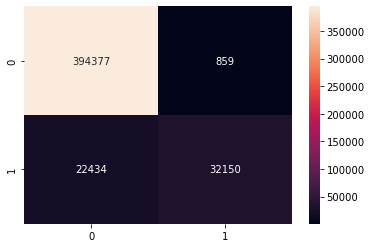

In [71]:
sns.heatmap(confusion_matrix(target_y, anomaly_prediction), annot = True, fmt = "d")